In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.model_selection import train_test_split
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import iqr
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [3]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [4]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

dataframe = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [6]:
#переименуем колонки для удобства 
dataframe = dataframe.rename(columns={'Restaurant_id': 'res_id', 'Cuisine Style': 'style', 'Price Range': 'price', 'City': 'city', 'Rating': 'rating', 'Number of Reviews': 'numberr', 'Ranking': 'ranking'})

In [7]:
dataframe.sample(15)

,res_id,city,style,ranking,price,numberr,Reviews,URL_TA,ID_TA,sample,rating
3549,id_3549,London,"['Bar', 'American', 'Vegetarian Friendly', 'Gl...",748.0,$$ - $$$,343.0,"[['good', 'Great burgers at Hache Shoreditch!'...",/Restaurant_Review-g186338-d3930775-Reviews-Ha...,d3930775,0,0.0
42726,id_13072,Paris,['French'],13074.0,$$ - $$$,59.0,"[['Shadowy terrace', 'Quick bite'], ['06/01/20...",/Restaurant_Review-g187147-d8275037-Reviews-Le...,d8275037,1,3.0
19807,id_4651,London,"['Spanish', 'Mediterranean', 'European']",4659.0,$$ - $$$,58.0,[['Excellent Spanish food with a great atmosp....,/Restaurant_Review-g186338-d2319901-Reviews-Ca...,d2319901,1,4.0
5300,id_5300,Vienna,"['German', 'Austrian', 'Cafe', 'European', 'Ce...",498.0,$$ - $$$,70.0,"[['Nice lunch, reasonable price with friendly....",/Restaurant_Review-g190454-d2627593-Reviews-Ca...,d2627593,0,0.0
6105,id_6105,Hamburg,['Indian'],2421.0,NaN,8.0,"[['Not bad', 'Quick and friendly-served Indian...",/Restaurant_Review-g187331-d980733-Reviews-Shi...,d980733,0,0.0
29100,id_5325,Madrid,NaN,5328.0,NaN,12.0,"[['Quick and friendly'], ['06/15/2016']]",/Restaurant_Review-g187514-d10215597-Reviews-L...,d10215597,1,3.5
48310,id_217,Munich,"['Italian', 'Mediterranean', 'European', 'Vege...",219.0,$$$$,288.0,"[['Very good Italian, well worth a visit.', 'E...",/Restaurant_Review-g187309-d1604985-Reviews-Os...,d1604985,1,4.0
24362,id_98,Rome,"['Italian', 'Seafood', 'Mediterranean', 'Conte...",99.0,$$ - $$$,611.0,"[['Great meal and great service', 'my restaura...",/Restaurant_Review-g187791-d8337471-Reviews-Il...,d8337471,1,4.5
48979,id_10011,London,NaN,10020.0,NaN,7.0,"[['Shepherds Pie still in Dalston', 'Tradition...",/Restaurant_Review-g186338-d5243357-Reviews-Ki...,d5243357,1,4.5
15776,id_1121,Oporto,NaN,1122.0,NaN,28.0,"[['Particularly interesting entries', 'Traditi...",/Restaurant_Review-g189180-d6165816-Reviews-Bi...,d6165816,1,3.5


In [8]:
#отбираем признаки с которыми будем работать
df = dataframe[['city', 'style', 'ranking', 'rating', 'price', 'numberr','sample']]

In [9]:
df

,city,style,ranking,rating,price,numberr,sample
0,Paris,"['Bar', 'Pub']",12963.0,0.0,$$ - $$$,4.0,0
1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,0.0,$$ - $$$,97.0,0
2,Edinburgh,['Vegetarian Friendly'],810.0,0.0,$$ - $$$,28.0,0
3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,0.0,$$$$,202.0,0
4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,0.0,$$$$,162.0,0
...,...,...,...,...,...,...,...
49995,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,4.5,$$ - $$$,79.0,1
49996,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,3.5,$$ - $$$,542.0,1
49997,Stockholm,"['Japanese', 'Sushi']",1652.0,4.5,NaN,4.0,1
49998,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,4.0,$$ - $$$,70.0,1


In [10]:
#ищем пустые значения
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   city     50000 non-null  object 
 1   style    38410 non-null  object 
 2   ranking  50000 non-null  float64
 3   rating   50000 non-null  float64
 4   price    32639 non-null  object 
 5   numberr  46800 non-null  float64
 6   sample   50000 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 2.7+ MB


In [11]:
#обрабатываем  колонку style
df['style'] = df['style']\
                        .apply(lambda x:  np.nan if pd.isna(x) else str(x).strip('[]').replace("'","").split(", ")) 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
df['style'].explode().value_counts(ascending=False)

Vegetarian Friendly    14021
European               12561
Mediterranean           7820
Italian                 7433
Vegan Options           5684
                       ...  
Fujian                     2
Salvadoran                 1
Xinjiang                   1
Burmese                    1
Latvian                    1
Name: style, Length: 125, dtype: int64

In [13]:

cus_list = df['style'].explode().value_counts(ascending=False)[:100].index.tolist() # c помощью среза мы определяем количество кухонь и топа по value_counts
for col in cus_list:
    if col not in df.columns:
        df[col] = df['style'].apply(lambda x: 1 if type(x)!=float and col in x   else 0)

# create column if all cuisines are not in top 3 list
df['Cuisine_else_all'] = df['style']\
                            .apply(lambda x: 1 if type(x)!=float and all([cus not in cus_list for cus in x]) else 0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

In [14]:
df #результат добавления кухонь

,city,style,ranking,rating,price,numberr,sample,Vegetarian Friendly,European,Mediterranean,...,Tibetan,Cajun & Creole,Afghani,Southwestern,Egyptian,Hawaiian,Tunisian,Cambodian,Singaporean,Cuisine_else_all
0,Paris,"[Bar, Pub]",12963.0,0.0,$$ - $$$,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,0.0,$$ - $$$,97.0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Edinburgh,[Vegetarian Friendly],810.0,0.0,$$ - $$$,28.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,0.0,$$$$,202.0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,0.0,$$$$,162.0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,4.5,$$ - $$$,79.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
49996,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,3.5,$$ - $$$,542.0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
49997,Stockholm,"[Japanese, Sushi]",1652.0,4.5,NaN,4.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,4.0,$$ - $$$,70.0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df['price'].isnull().value_counts() #проверяем пропуски в столбце price

False    32639
True     17361
Name: price, dtype: int64

In [16]:
df['price']=df.price.fillna(value='$') #заменяем пропуски


33.0
количесnво пропусков False    50000
Name: rating, dtype: int64


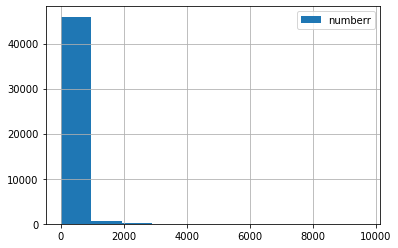

In [17]:
#смотрим на количество отзывов


df["numberr"].hist(bins=10,legend=True)
print(df["numberr"].median())
print('количесnво пропусков',df['rating'].isnull().value_counts())

25-й перцентиль: 9.0, 75-й перцентиль: 115.0, IQR: 106.0,  Границы выбросов: [-150.0, 274.0].


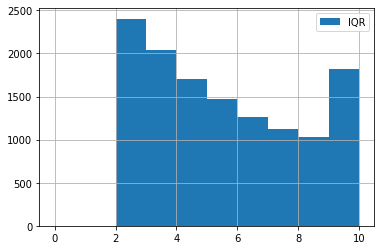

In [18]:
#Более детально 
IQR = df.numberr.quantile(0.75) - df.numberr.quantile(0.25)
perc25 = df.numberr.quantile(0.25)
perc75 = df.numberr.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
 
df.numberr.loc[df.numberr.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), label = 'IQR')
 
plt.legend();

In [19]:
#Чистим numberr от выбросов
df['numberr'] = df.numberr[df.numberr.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
df['numberr']=df.numberr.fillna(df.numberr.median())

median 4.0
количесnво пропусков False    50000
Name: rating, dtype: int64


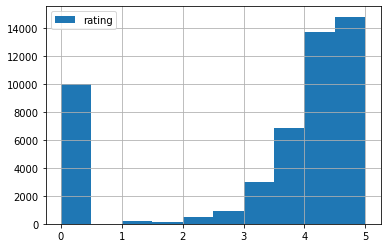

In [20]:
#Смотрим на rating
df["rating"].hist(bins=10,legend=True)
print('median',df["rating"].median())
print('количесnво пропусков',df['rating'].isnull().value_counts())


median 2278.0
количесnво пропусков False    50000
Name: ranking, dtype: int64


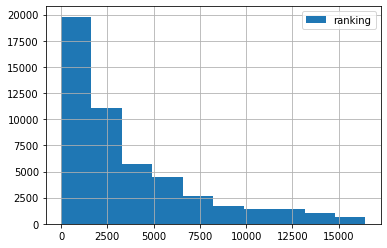

In [21]:
#Смотрим на ranking
df["ranking"].hist(bins=10,legend=True)
print('median',df["ranking"].median())
print('количесnво пропусков',df['ranking'].isnull().value_counts())


In [22]:
df.sample(5)

,city,style,ranking,rating,price,numberr,sample,Vegetarian Friendly,European,Mediterranean,...,Tibetan,Cajun & Creole,Afghani,Southwestern,Egyptian,Hawaiian,Tunisian,Cambodian,Singaporean,Cuisine_else_all
15437,Munich,[American],2559.0,3.0,$,25.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41116,Brussels,"[Fast Food, Soups, Vegetarian Friendly]",1351.0,4.0,$,29.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
35866,Amsterdam,"[Italian, Mediterranean, Pizza]",1693.0,4.5,$$ - $$$,22.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
27841,Paris,"[Italian, European]",8525.0,3.5,$$ - $$$,118.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8064,Lisbon,"[Mediterranean, European, Portuguese]",2520.0,0.0,$$ - $$$,66.0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


# Создаем новые признаки

In [23]:
# добавляем города
df2 =pd.get_dummies(df.city, drop_first=False)
df3=pd.concat([df,df2],sort=False,axis=1)
df3

,city,style,ranking,rating,price,numberr,sample,Vegetarian Friendly,European,Mediterranean,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
0,Paris,"[Bar, Pub]",12963.0,0.0,$$ - $$$,4.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,0.0,$$ - $$$,97.0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Edinburgh,[Vegetarian Friendly],810.0,0.0,$$ - $$$,28.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,0.0,$$$$,202.0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,0.0,$$$$,162.0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,4.5,$$ - $$$,79.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
49996,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,3.5,$$ - $$$,25.0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
49997,Stockholm,"[Japanese, Sushi]",1652.0,4.5,$,4.0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
49998,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,4.0,$$ - $$$,70.0,1,1,1,0,...,0,0,0,0,0,0,0,0,1,0


In [24]:
#добавляем price
df4 = pd.get_dummies(df.price, drop_first=False)
df3=pd.concat([df3,df4],sort=False,axis=1)
df3

,city,style,ranking,rating,price,numberr,sample,Vegetarian Friendly,European,Mediterranean,...,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,$,$$ - $$$,$$$$
0,Paris,"[Bar, Pub]",12963.0,0.0,$$ - $$$,4.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,0.0,$$ - $$$,97.0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
2,Edinburgh,[Vegetarian Friendly],810.0,0.0,$$ - $$$,28.0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,0.0,$$$$,202.0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,0.0,$$$$,162.0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,4.5,$$ - $$$,79.0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
49996,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,3.5,$$ - $$$,25.0,1,1,1,0,...,1,0,0,0,0,0,0,0,1,0
49997,Stockholm,"[Japanese, Sushi]",1652.0,4.5,$,4.0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
49998,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,4.0,$$ - $$$,70.0,1,1,1,0,...,0,0,0,0,0,1,0,0,1,0


In [25]:
#Создаем новые признаки и эксперементиуем
df3['nw']=df3['rating']/df3['numberr']*df3['ranking']

In [26]:
df3.columns

Index(['city', 'style', 'ranking', 'rating', 'price', 'numberr', 'sample',
       'Vegetarian Friendly', 'European', 'Mediterranean',
       ...
       'Prague', 'Rome', 'Stockholm', 'Vienna', 'Warsaw', 'Zurich', '$',
       '$$ - $$$', '$$$$', 'nw'],
      dtype='object', length=143)

In [27]:
#удоляем обработанные столбцы
df3=df3.drop(['city','style','price'], axis=1)

In [28]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 140 entries, ranking to nw
dtypes: float64(4), int64(102), uint8(34)
memory usage: 42.1 MB


# Подготавливаем модель

In [29]:
#делим общий дата сет по сэмплу
train_data = df3.query('sample == 1').drop(['sample'], axis=1)
test_data = df3.query('sample == 0').drop(['sample'], axis=1)
y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)
RANDOM_SEED = 42

In [30]:
#Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
#выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [31]:
#проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 139), (40000, 139), (40000, 138), (30000, 138), (10000, 138))

# Тест модели


In [32]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [33]:
X_train

,ranking,numberr,Vegetarian Friendly,European,Mediterranean,Italian,Vegan Options,Gluten Free Options,Bar,French,...,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,$,$$ - $$$,$$$$,nw
36898,871.0,51.0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,76.852941
37635,1943.0,4.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2428.750000
13036,2798.0,7.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1598.857143
15604,1644.0,14.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,528.428571
46111,1719.0,25.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,275.040000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16265,2235.0,28.0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,279.375000
21284,1604.0,21.0,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,343.714286
48158,2070.0,13.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,636.923077
10860,18.0,25.0,1,0,1,1,1,0,0,0,...,0,1,0,0,0,0,1,0,0,3.240000


In [34]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [35]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1579225


<AxesSubplot:>

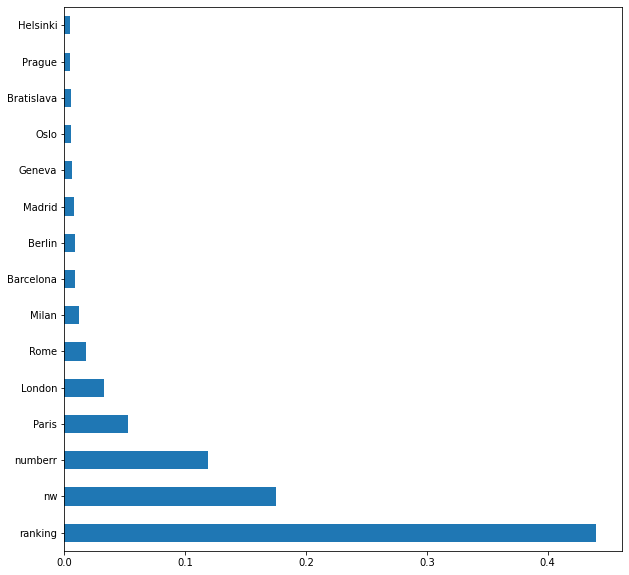

In [36]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission


In [37]:
test_data.sample(130)

,ranking,rating,numberr,Vegetarian Friendly,European,Mediterranean,Italian,Vegan Options,Gluten Free Options,Bar,...,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,$,$$ - $$$,$$$$,nw
8696,3687.0,0.0,133.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
6946,3846.0,0.0,8.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
4951,1891.0,0.0,25.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0.0
5788,257.0,0.0,25.0,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0.0
4456,309.0,0.0,159.0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9544,2756.0,0.0,25.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
3170,741.0,0.0,46.0,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0.0
3816,3095.0,0.0,70.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
5404,1126.0,0.0,39.0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0.0


In [38]:
test_data = test_data.drop(['rating'], axis=1)

In [39]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [40]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [41]:
sample_submission['rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating,rating
0,id_0,2.0,2.685
1,id_1,2.5,4.170
2,id_2,4.0,3.600
3,id_3,1.0,4.245
4,id_4,4.0,4.450
5,id_5,4.5,3.290
6,id_6,4.5,1.095
7,id_7,2.0,1.110
8,id_8,2.0,3.365
9,id_9,3.5,3.770
